In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.linear_model import LinearRegression as lr
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
os.chdir('C:\\Users\\VanBuren\\Desktop\\Coursework\\Capstone\\Coding_analysis\\Test_Data')

In [13]:
#NYDEC CALIBRATION SCHEME
#----USEFUL FOR NON-SUBWAY CALIBRATIONS: INDOOR/OUTDOOR TIME.
#designate timespan we want
start = dt.datetime.strptime('2020-07-10', '%Y-%m-%d')
end = dt.datetime.strptime('2021-01-27', '%Y-%m-%d')

#Read in the NY DEC data, combine date/time columns into one datetime field for easier analysis
refdata = pd.read_csv('nydec.csv',header = 1,parse_dates=[['Date','Time']]).rename(columns={"PM25C_ug/m3LC":"PM2.5_ref"})

#Localize refdata to UTC (then remove timezone awareness)
refdata['Date_Time'] = refdata['Date_Time'].dt.tz_localize('US/Eastern', ambiguous = 'NaT').dt.tz_convert('UTC').dt.tz_localize(None)
refdata = refdata.loc[(refdata['Date_Time'] >= start) & ((refdata['Date_Time'] < end))]
refdata = refdata.set_index(refdata.Date_Time)

#read in purpleair datasets: hour averages (for best comparison to refdata data)
#then limit range of PA sensor data to desired timespan
#then set index to timestamp
sensA = pd.read_csv('school_4_A_hr.csv',header = 0).rename(columns={"Temperature_F":"Temp","PM2.5_ATM_ug/m3":"PM2.5A"})

#convert to eastern time (if refdata not converted to UTC)
# sensA['created_at'] = pd.to_datetime(sensA['created_at']).dt.tz_convert('US/Eastern')
#remove localization
sensA['created_at'] = pd.to_datetime(sensA['created_at']).dt.tz_localize(None)
sensA = sensA.loc[(sensA['created_at'] >= start) & ((sensA['created_at'] < end))]
sensA = sensA.set_index(sensA.created_at)


sensB = pd.read_csv('school_4_B_hr.csv',header = 0).rename(columns={"PM2.5_ATM_ug/m3":"PM2.5B"})
# sensB['created_at'] = pd.to_datetime(sensB['created_at']).dt.tz_convert('US/Eastern')
sensB['created_at'] = pd.to_datetime(sensB['created_at']).dt.tz_localize(None)
sensB = sensB.loc[(sensB['created_at'] >= start) & ((sensB['created_at'] < end))]
sensB = sensB.set_index(sensB.created_at)

#Get all info onto a single dataframe
df = pd.concat([sensA[['Temp','Humidity_%','PM2.5A']], sensB['PM2.5B'], refdata['PM2.5_ref']], axis = 1)
df['PM2.5_test'] = df[['PM2.5A','PM2.5B']].mean(axis = 1)
#Null values gonna screw up statswork later on, so let's ditch now
df = df.loc[df['PM2.5_ref'].notnull() & df['PM2.5_test'].notnull() & df['Temp'].notnull() & df['Humidity_%'].notnull()]
df

#statswork for multiple regression
#Parameters for regression in X, assume they're predictors for nydec data as y

#trained model: nydec = x0 + x1[temp] + x2[humidity] + x3[PA data]

X = np.array(df[['Temp','Humidity_%','PM2.5_test']])
y = np.array(df['PM2.5_ref'])
reg = lr(fit_intercept = False).fit(X,y)

reg_out = lambda o: np.dot(o,reg.coef_)
#R-square:
print(reg.score(X,y))

#run that model on the parameters
df['PM2.5_calib'] = np.dot(X,reg.coef_)

0.5328656567210689


In [31]:
print((scipy.stats.pearsonr(df['PM2.5_test'],df['PM2.5_ref'])[0])**2)

0.5578051360301065


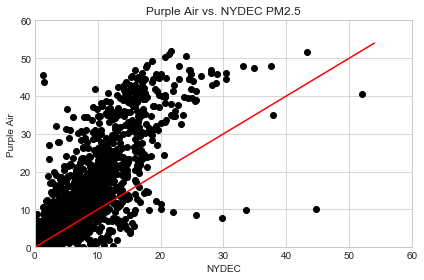

In [39]:
fig, ax = plt.subplots()
ax.scatter(df['PM2.5_ref'],df['PM2.5_test'],color = 'black')
# 1:1 line for quick eyeballing
x1 = np.arange(0,55)
y1 = x1
ax.plot(x1,y1, '-r')
# ax.text(49,5,"r^2 = 0.5578",bbox=dict(facecolor='white', alpha=1),**dict(size=11,color='black'))
# ax.text(40,36,"1:1 line",bbox=dict(facecolor='white', alpha=1),**dict(size=11,color='red'))
ax.set(title = 'Purple Air vs. NYDEC PM2.5',ylabel = "Purple Air", xlabel = "NYDEC")
ax.set_xlim(left = 0, right = 60)
ax.set_ylim(bottom = 0, top = 60)




fig.tight_layout()

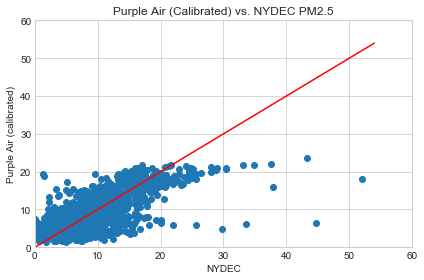

In [33]:
fig, ax2 = plt.subplots()
ax2.scatter(df['PM2.5_ref'],df['PM2.5_calib'])
x2 = np.arange(0,55)
y2 = x2
ax2.plot(x2,y2,'-r')
# ax2.text(49,5,"r^2 = 0.5578",bbox=dict(facecolor='white', alpha=1),**dict(size=11,color='blue'))
ax2.set(title = 'Purple Air (Calibrated) vs. NYDEC PM2.5',
        ylabel = "Purple Air (calibrated)", xlabel = "NYDEC")
ax2.set_xlim(left = 0, right = 60)
ax2.set_ylim(bottom = 0, top = 60)
fig.tight_layout()

[Text(0,0.5,'Calibrated PA PM2.5'),
 Text(0.5,0,'NYDEC PM2.5 readings'),
 Text(0.5,1,'Calibrated vs. reference PM2.5')]

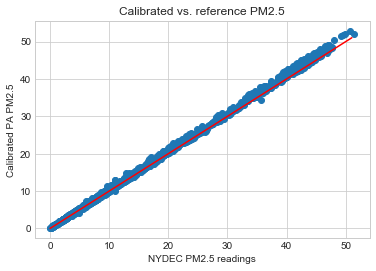

In [6]:
#visualization cell

fig,ax = plt.subplots()
#Plot reference data vs purpleair data
ax.scatter(df['PM2.5A'],df['PM2.5B'])

#1:1 line for quick eyeballing
x1 = np.arange(df['PM2.5A'].min(),df['PM2.5A'].max())
y1 = x1
ax.plot(x1,y1, '-r')
ax.set(title = 'Calibrated vs. reference PM2.5',xlabel = "NYDEC PM2.5 readings", ylabel = "Calibrated PA PM2.5")
#regression line of best fit
#y2 = reg.intercept + reg.slope * x1
#x.plot(x1,y2)

In [ ]:
reg.score(X,y)**0.5

In [ ]:
r,p = scipy.stats.pearsonr(df['PM2.5_calib'],df['PM2.5_ref'])
r

In [7]:
#CALIBRATION SCHEME B
#Luglio curve--meant for on the train platforms
# reg_plat = lambda p: 5.1338 * p**0.8681

#Platforms model based on Ben's data:
# reg_plat = lambda p: 1.6749 * p + 1.5295

# K finally got the filters
filt = pd.read_csv('Gravcal.csv',header = 0)


X = np.column_stack([np.zeros(len(filt['PA PM2.5 avg'])),filt['PA PM2.5 avg']])
y = np.array(filt['Grav(average)'])
calibs = lr(fit_intercept = False).fit(X,y)
reg_plat = lambda p: calibs.coef_[1]*p

In [8]:
# Calibration Scheme C
# For dealing with PA and aboveground trains:
reg_sir = lambda q: q*(30.9/36.2)


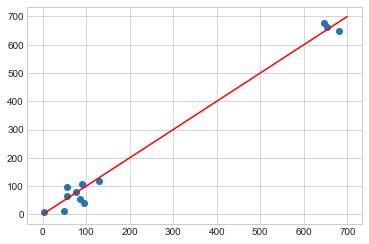

In [18]:
fig,ax = plt.subplots()
ax.scatter(reg_plat(filt['PA PM2.5 avg']),filt['Grav(average)'])
x1 = np.arange(0,700)
y1 = x1
ax.plot(x1,y1, '-r')

In [5]:
# How's about offloading calibrations to just one function
def calibrate(frame):
    #Establish which code gets calibrated how
    codes_nydec = ['O','I','F']
    codes_luglio = ['PU','T','E']
    codes_sir = ['PA']
    #then calibrate based on Loc_code
    frame['PM2.5_calib'] = np.nan
    
    #nydec calibration
    frame['PM2.5_calib'].loc[frame['Loc_code'].isin(codes_nydec)] = reg_out(
        frame[['Temp','Humidity_%','PM2.5']].loc[frame['Loc_code'].isin(codes_nydec)])
    #luglio calibration
    frame['PM2.5_calib'].loc[frame['Loc_code'].isin(codes_luglio)] = reg_plat(
        frame['PM2.5'].loc[frame['Loc_code'].isin(codes_luglio)])
        #SIR calibration for aboveground plats
    frame['PM2.5_calib'].loc[frame['Loc_code'].isin(codes_sir)] = reg_sir(
        frame['PM2.5'].loc[frame['Loc_code'].isin(codes_sir)])
    #Special aboveground train calibration using SIR
    frame['PM2.5_calib'].loc[(frame['Loc_code']=='T') & (frame['Outside? (Y/N)'] == 'Y')] = reg_sir(
        frame['PM2.5'].loc[(frame['Loc_code']=='T') & (frame['Outside? (Y/N)'] == 'Y')])
    return frame


In [8]:
# Keeping the other imports below for posterity and/or potential emergencies? idk, just don't wanna delete yet
dfsub = pd.read_csv('Master_compiled_BB.csv',header = 0, parse_dates = [['Date', 'Time_NYC']]).rename(
    columns = {'Temperature (F)': 'Temp','Humidity (%)':'Humidity_%','PA PM2.5 (um/m3)':'PM2.5'})

dfsub = dfsub.loc[dfsub['PM2.5'].notnull() & dfsub['Temp'].notnull() & dfsub['Humidity_%'].notnull() & 
                  dfsub['Location'].notnull()]
dfsub = calibrate(dfsub)
# dfsub.loc[(dfsub['Loc_code']=='T') & (dfsub['Outside? (Y/N)'] == 'Y')]
dfsub.to_csv('Masterlist.csv')

C:\Users\VanBuren\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
#PLAYING AROUND WITH BEN'S SUBWAY TRIP DATA
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------
dfsub = pd.read_csv('subwaytrip_test.csv',header = 0,parse_dates=[['date','NYC time']]).rename(
    columns = {'PM2.5 ug/m3_sensorA':'PM2.5','particles/m3_sensA':'particles/m3', 'Temp (F)':'Temp','RH (%)':'Humidity_%'})
dfsub = dfsub.drop(columns = 'Unnamed: 9')
# dfsub = dfsub.set_index(dfsub['date_NYC time'])

dfsub = dfsub.loc[dfsub['PM2.5'].notnull() & dfsub['Temp'].notnull() & dfsub['Humidity_%'].notnull()]

dfsub = calibrate(dfsub)
# #which lets us compare avg concentrations
# outair1 = np.mean(dfsub['PM2.5_calib'].loc[dfsub['Loc_code'] == 'O'])
# tcarair1 = np.mean(dfsub['PM2.5_calib'].loc[dfsub['Loc_code'] == 'T'])
# platair1 = np.mean(dfsub['PM2.5_calib'].loc[dfsub['Loc_code'] == 'PU'])

# outraw1 = np.mean(dfsub['PM2.5'].loc[dfsub['Loc_code'] == 'O'])
# tcarraw1 = np.mean(dfsub['PM2.5'].loc[dfsub['Loc_code'] == 'T'])
# platraw1 = np.mean(dfsub['PM2.5'].loc[dfsub['Loc_code'] == 'PU'])

# print(outair1, tcarair1, platair1)

#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------

In [ ]:
#greg's mar 3 data
dfgh3 = pd.read_csv('GH_Mar3.csv',header = 0, parse_dates=[['date','time_est']]).rename(
    columns = {'current_temp_f':'Temp','current_humidity':'Humidity_%'})
dfgh3 = dfgh3.set_index(dfgh3['date_time_est'])
dfgh3 = calibrate(dfgh3)
# dfgh3

In [ ]:
# K, let's see about looping through the data to take care of it instead.
# dfsub can be base, then noah's data just concat'd onto it.
dfnp = pd.read_csv('NP_Feb4.csv',header = 0) #messed up the file, so this one goes on separate
dfsub = pd.concat([dfsub,dfnp,dfgh3])


datasets = ['NP_Feb13.csv']

for i in datasets:
    dfi = pd.read_csv(i,header = 0,parse_dates=[['date','NYC time']]).rename(
        columns = {'PM2.5 ug/m3_sensorA':'PM2.5','particles/m3_sensA':'particles/m3', 'Temp (F)':'Temp','RH (%)':'Humidity_%'})
#     dfi = dfi.set_index(dfi['date_NYC time'])
    dfi = dfi.loc[dfi['PM2.5'].notnull() & dfi['Temp'].notnull() & dfi['Humidity_%'].notnull()]
    dfi = calibrate(dfi)
    dfsub = pd.concat([dfsub,dfi]) 
dfsub = dfsub[['date_NYC time','Temp','Humidity_%','AQI_pm2.5','P (mbar)','particles/m3','PM2.5','PM2.5_calib','Loc_code']]
# pd.to_csv('Masterlist.csv')

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------

In [ ]:
#Upcoming viz's and analyses we'll be wanting:
#might need to calibrate time series based on something particle count, rather than nydec

#SO: --alternative calibration schemes

#--Gen purpose code for integrating over a time series will be immensely useful.
#    maybe something like np.cumsum() would be fine here?
#    alternatively figure out scipy.integrate.quad

#--Resolve challenges w/ air densities via quick & dirty like "average volume of air in a breath" or something.
#--plan would be to compare against like an average day at home.

#seems like general form would be something like:
# from scipy import integrate
# model = [whatever we fit to our subway data]
# y,err = integrate.quad(model,0,[endtime])

# cumsum seems like it'd probably be simpler to use, given discrete data collection, but idk how concentrations play into
# that, conceptually



#2/6 update: we'd maybe want to present info in ug/min. Analysis is made a lot simpler by the fact that we got sensors
#    collecting in discrete AND consistent time chunks
#    and if we can get a breakdown of what chemicals are in the PM2.5, could even do like toxicity exposure a la Garvey's
#    stuff

#2/16:
#tasks for the next bit:
#  work in Luglio calibration curve for calibrations, and expect that we'll
#  have updated method once steve's stuff gets over to Ben
#  Graph work:
#    Generate two: one raw, one entirely calibrated
#    Get error bars onto them (figure out how to get error with sklearn) (and how to put them
#    onto the plot)


In [ ]:
# Exposure analyses probably gonna involve factors re: volume of air a human takes per breath & number breaths in a timespan
# shelby recommends researching athsma diagnostic criteria for quick info on air intakes

# vol/breath (m^3)
# at rest, seems to be 0.5 liters, active ranges from 3-5 liters. Figure walking for low end of that
lungs_rest = 0.0005
lungs_walk = .003

# breaths/time
#rest range seems to be 12-20 per min, exercise goes 30-50. Unclear re: walking specifically, let's just say average of 25
brate_rest = 18
brate_walk = 25

#then the timespan we're measuring over I guess depends on how we analyze.
#for sake of filling in a column on the combined dataframe I guess let's default to 2 minutes
time_base = 2

# to untangle concentration: df['PM2.5_calib'] * lungs_rest * brate_rest * time_base

# df['mass_exp_step'] = df['PM2.5_calib'] * lungs_rest * brate_rest * time_base

# should also keep in mind that avg of avges = avg all datapoints
# and that doing this saves us having to integrate to evaluate stuff, since the data's discrete and consistent.

In [ ]:
# ---------------------------------------------------------------------------------------------------------
# ugh trying to remember how ADD works.

# baseline: ADD = concentration * ingestion_rate * (exposure_factor) / weight
# and then exposure_factor = frequency * duration / "averaging time"
# frequency: days/year; duration: years; avging time: duration(years) * 365 days/year

# so something like:
weight = 70 #kg--default assumption for non-children
concentration = # mg/m^3--the avg concentration of exposure on subway trips. Which, we've established that average of every
#                   concentration reading taken is the same as the cumulative concentration for that timespan.

ingestion_rate = lungs_walk * brate_walk * 3600 #m^3/breath * breath/min * min/day: m^3/day air intake

frequency = 180 # days/year--number of school days (if memory serves, look this up.)
duration = 3 # years--let's say 3 years is number of years going to the schools
avging_time = 3 * 365

# ok think I got it; the whole averaging time/exposure factor rigamarole is to account for how the daily exposure isn't
#   literally every day of the year--some days won't have exposure. so turns into average *daily* daily dose, not just 
#   daily dose on exposure days.

ef = frequency*duration/avging_time

add = concentration * ingestion_rate * ef/weight

risk_carc = add*slope_factor #defined elsewhere
risk_nonc = add/ref_dose #also defined elsewhere

# So assembling it this way in terms of risk factor won't necessarily give us the scariest possible exposure number
#   (we can easily get that by avging T&P loc codes anyway), but could set us up for stuff like comparing to EPA benchmarks

